Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08000611708382449..30.199196887753956].


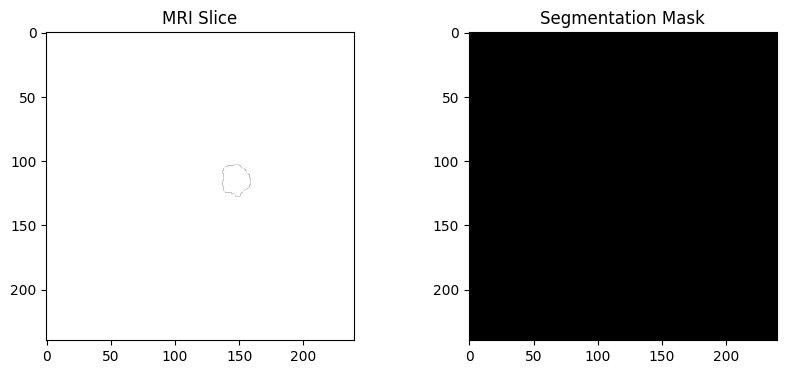

In [7]:
import h5py
import matplotlib.pyplot as plt

# Path to one of your slice files
file_path = './data/BraTS/BraTS2020_training_data/content/data/volume_47_slice_1.h5'

# Open the file
with h5py.File(file_path, 'r') as f:
    image = f['image'][:]
    mask = f['mask'][:]  # If available

# Display
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('MRI Slice')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='Reds')
plt.title('Segmentation Mask')

plt.show()